In [1]:
%matplotlib inline


# Sıfırdan NLP: Karakter Düzeyinde RNN ile İsimler Oluşturma

Bu, "Sıfırdan NLP" konulu üç eğitimden ikincisidir.
ilk eğitimde `char_rnn_classification_tutorial`
isimleri menşei dillerine göre sınıflandırmak için bir RNN kullandık. Şimdi ise
geri dönüp dillerden isimler üreteceğiz. İlk eğitime `github.com/htsk0180` adresinden ulaşabilirsiniz.

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

Hala birkaç doğrusal katmanla küçük bir RNN yapıyoruz. Büyük
fark, tümünü okuduktan sonra bir kategoriyi tahmin etmek yerine
Bir ismin harfleri, bir kategori gireriz ve her seferinde bir harf çıkarırız.
Dili oluşturmak için karakterleri tekrar tekrar tahmin etme işlemini yapacağız.(bu aynı zamanda
kelimelerle veya diğer üst düzey yapılarla yapılan).

**Önerilen Kaynaklar:**

-  https://pytorch.org/ Kurulum talimatları için,
-  `/beginner/deep_learning_60min_blitz` genel olarak PyTorch'a başlamak için,
-  `/beginner/pytorch_with_examples` geniş ve derin bir genel bakış için,
-  `/beginner/former_torchies_tutorial` eski Lua Torch kullanıcısıysanız
yukarıda vermiş olduğum kaynaklara kesinlikle göz atınız.


RNN'ler ve nasıl çalıştıkları hakkında bilgi sahibi olmak içinse: 

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## Verilerin Hazırlanması

.. Not::
   Verileri şu adresten indirin,
   [veri](https://download.pytorch.org/tutorial/data.zip)
   ve geçerli dizine çıkartın.

dizin bu şekilde olmalı: ``data/names/[Language].txt`` 
ve sonrasında veri yapısu bu şekilde olmalı, veri yapısını bu şekle almak için aşağıda bir fonksiyonumuz var merak etmeyin. bu fonksiyonları doğrudan yazabilrsiniz yada ihtiyacınız olduğunda copy/paste yapabilirsiniz. ``{language: [names ...]}``.


In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # ekstra olarak + işareti.

def findFiles(path): return glob.glob(path)

# Bir Unicode dizesini düz ASCII'ye çevirin, teşekkürler https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Bir dosyayı okuyun ve satırlara bölün
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Category_lines sözlüğünü, kategori başına satırların bir listesini oluşturun
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Veri bulunamadı. Verileri indirdiğinizden emin olun '
        'veri adresinden indirebilirsiniz --> https://download.pytorch.org/tutorial/data.zip ve ilgili klasöre veriyi çıkartın ')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'Korean', 'Italian', 'Spanish', 'Vietnamese', 'Irish', 'Russian', 'English', 'Japanese', 'Dutch', 'German', 'Chinese', 'Portuguese', 'Greek', 'Polish', 'Arabic', 'Scottish', 'French']
O'Neal


## Ağı Oluşturma



Çıktıyı bir sonraki harfin olasılığı olarak yorumlayacağız. en olası çıktı harfi bir sonraki girdi olarak kullanılır. Ve RNN böylece devam edecek, sonrasında ise nihai çıktıya erişeceğiz.

[bu makaleye bir göz atın, temel mimarimizde burdaki sezgisel fikirleri ve önerileri kullanacağız.](https://arxiv.org/abs/1207.0580)


In [5]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [12]:
# model parametrelerini rastgele vererek modelimize göz atalım.
model = RNN(128,128,29)
print(model)

RNN(
  (i2h): Linear(in_features=274, out_features=128, bias=True)
  (i2o): Linear(in_features=274, out_features=29, bias=True)
  (o2o): Linear(in_features=157, out_features=29, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


## Eğitim
Eğitime Hazırlanmak
----------------------

Her şeyden önce, rastgele çiftleri (kategori, satır) elde etmek için yardımcı işlevleri yazalım




In [13]:
import random

# Bir listeden rastgele öğe
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Rastgele bir kategori ve bu kategoriden rastgele bir satır alın
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

Her bir zaman adımı için (yani bir eğitim sözcüğündeki her harf için)
ağın girişleri olacak
``(category, current letter, hidden state)``ve çıktılar olacak
``(next letter, next hidden state)``.Yani her eğitim seti için
kategoriye, bir dizi giriş harfine ve bir dizi çıktı/hedefe ihtiyacımız var.

Her biri için mevcut harften bir sonraki harfi tahmin ettiğimiz için
zaman adımında, harf çiftleri ardışık harf gruplarıdır.
 - örneğin ``"ABCD<EOS>"`` için şu şekilde bir eğitim seti oluşturabiliriz. ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

[one-hot
tensor](https://en.wikipedia.org/wiki/One-hot)of size
``<1 x n_categories>`` büyüklüğünde one-hot kodlanmış tensörü her seferinde ağımıza besleriz.



In [14]:
# Kategori için sıcak vektör
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# Giriş için ilk ve son harflerden oluşan tek sıcak matris (EOS hariç)
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# Hedef için ikinci harfin sona ermesi (EOS) LongTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

Eğitim sırasında kolaylık sağlamak için bir "randomTrainingExample" yapacağız
Rastgele (category, line) bir çift getiren ve bunları şuna dönüştüren işlev:(category, input, target)



In [15]:
# Rastgele bir kategori, satır çiftinden kategori, giriş ve hedef tensörler yapın
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### Ağı Eğitmek

Yalnızca son çıktının kullanıldığı sınıflandırmanın aksine,
her adımda bir tahmin yapıyoruz, bu nedenle her adımda kaybı hesaplıyoruz.


Autogradla bu işlemi yani kayıp sonrası geri yayılımı kolaylıkla hesaplayabiliriz.




In [16]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [17]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [18]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 16s (5000 5%) 2.2681
0m 32s (10000 10%) 2.5297
0m 47s (15000 15%) 2.2971
1m 3s (20000 20%) 2.0926
1m 19s (25000 25%) 2.2893
1m 34s (30000 30%) 1.1759
1m 50s (35000 35%) 2.8000
2m 5s (40000 40%) 1.9567
2m 22s (45000 45%) 2.3224
2m 37s (50000 50%) 2.6686
2m 52s (55000 55%) 2.2451
3m 8s (60000 60%) 2.8258
3m 24s (65000 65%) 2.2648
3m 39s (70000 70%) 2.1794
3m 55s (75000 75%) 1.9633
4m 11s (80000 80%) 2.8018
4m 27s (85000 85%) 2.0062
4m 42s (90000 90%) 2.0739
4m 58s (95000 95%) 1.8605
5m 14s (100000 100%) 2.6454


### Kaybı görselleştirelim.




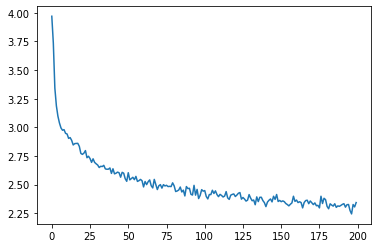

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## Test edelim.

Örneklemek için ağa bir veri veriyoruz ve bir sonrakinin ne olduğunu soruyoruz,
bunu bir sonraki harf olarak girin ve EOS belirtecine kadar tekrarlayın.

- input category, starting letter, ve empty hidden state için tensörler oluşturun
- Başlangıç harfiyle bir ``output_name`` dizisi oluşturun
- Maksimum çıkış uzunluğuna kadar,

    - Geçerli veriyle ağı besleyin
    - En yüksek çıkıştan bir sonraki harfi ve bir sonraki gizli durumu alın
    - Harf EOS ise burada durun
    - Normal bir harf ise ``output_name`` kısmına ekleyin ve devam edin

- Sonra adımları tekrarlayın.

.. Not::
    Ağa bir başlangıç verisi vermek yerine, başka bir
    strateji olarak, bir "dizinin başlangıcı" belirtecini dahil etmek olurdu.
    Eğitim ve ağın kendi başlangıç harfini seçmesini sağlamış olurduk kısaca..




In [20]:
max_length = 20

# Bir kategoriden örnek ve başlangıç verisi.
def sample(category, start_letter='A'):
    with torch.no_grad():  # örneklemede geçmişi izlemeye gerek yok
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Bir kategoriden birden çok örnek ve birden çok başlangıç harfi alın
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roulan
Uantan
Sharavav
Gelleng
Eringer
Romer
Sarana
Pares
Arana
Chung
Hang
Iun
